<center>
    <h1 style="color:DarkRed;font-size:40px"><b>House Prices - Advanced Regression Techniques</b></h1>
</center>

<center><img src="house.jpeg" width=600 height=400 />

# **Descrição do problema**

Este notebook será utilizado para resolução do problema proposto na <a href="https://www.kaggle.com/c/house-prices-advanced-regression-techniques/overview">Competição House Price Prediction</a>, disponibilizada pelo Kaggle. O objetivo é prever o valor das casas com base numa série de atributos, como tamanho, número de quartos, etc.

Com isso em mente, ao longo deste notebook serão desenvolvidas as tarefas:
- Análise exploratória, limpeza e manipulação dos dados;
- Criação de gráficos para visualização dos dados;
- Construção de modelos preditivos, buscando testar diferentes algoritmos de regressão.

# **Importação das bibliotecas**

In [152]:
import pandas as pd
from ydata_profiling import ProfileReport
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, MinMaxScaler, RobustScaler, StandardScaler, OrdinalEncoder
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import warnings
from eli5.sklearn import PermutationImportance
import eli5
from sklearn.metrics import mean_squared_error
from math import sqrt
import shap
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor
from xgboost import XGBRegressor
from sklearn.svm import LinearSVR, SVR
import pickle
warnings.filterwarnings('ignore')
%matplotlib inline

# **Análise exploratória, limpeza e manipulação dos dados**

In [3]:
#carregando o conjunto de dados de treino
dados_treino = pd.read_csv('Dados/train.csv', index_col = 'Id')
dados_treino.sample(5)

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
Id,,,,,,,,,,,,,,,,,,,,,
832,160,FV,30.0,3180,Pave,Pave,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,6,2006,WD,Normal,151000
116,160,FV,34.0,3230,Pave,Pave,Reg,Lvl,AllPub,Corner,...,0,NaN,NaN,NaN,0,6,2007,WD,Normal,176000
139,60,RL,73.0,9066,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,NaN,GdPrv,NaN,0,12,2008,WD,Normal,230000
996,50,RL,51.0,4712,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,NaN,MnPrv,NaN,0,8,2006,WD,Abnorml,121600
1062,30,C (all),120.0,18000,Grvl,NaN,Reg,Low,AllPub,Inside,...,0,NaN,NaN,Shed,560,8,2008,ConLD,Normal,81000


In [4]:
dados_treino.shape

(1460, 80)

In [5]:
#quantidade de dados categóricos e numéricos (-1 de SalePrice)
quantidade_textuais = dados_treino.select_dtypes('object').shape[1]
quantidade_numericos = dados_treino.select_dtypes(exclude=['object']).shape[1] - 1
print('Quantidade de dados textuais: %d' % quantidade_textuais)
print('Quantidade de dados numéricos: %d' % quantidade_numericos)

Quantidade de dados textuais: 43
Quantidade de dados numéricos: 36


In [6]:
#verificando se há valores duplicados
dados_treino.duplicated().sum()

0

In [7]:
#verificando presença de valores nulos
dados_treino.isnull().sum()[dados_treino.isnull().sum() > 0]

LotFrontage      259
Alley           1369
MasVnrType         8
MasVnrArea         8
BsmtQual          37
BsmtCond          37
BsmtExposure      38
BsmtFinType1      37
BsmtFinType2      38
Electrical         1
FireplaceQu      690
GarageType        81
GarageYrBlt       81
GarageFinish      81
GarageQual        81
GarageCond        81
PoolQC          1453
Fence           1179
MiscFeature     1406
dtype: int64

In [8]:
dados_treino[(dados_treino.GarageType.isnull()) & (dados_treino.GarageYrBlt.isnull())].shape[0]

81

Text(0.5, 1.0, 'Histograma dos Valores de Venda')

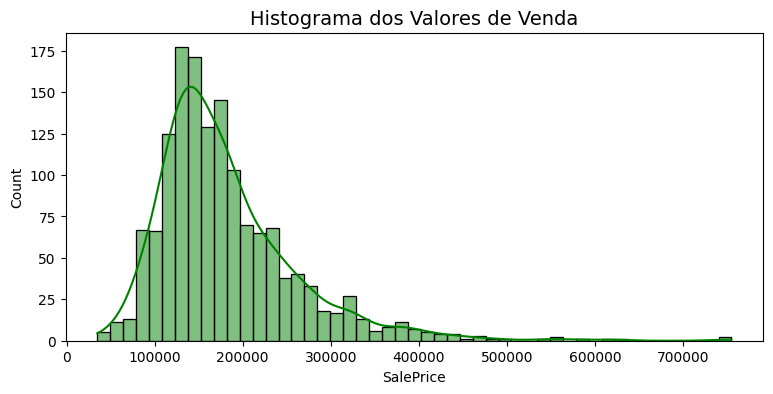

In [9]:
#distribuição dos valores de venda
plt.figure(figsize=(9,4))
sns.histplot(dados_treino.SalePrice, kde = True, legend = False, color = 'green')
plt.title('Histograma dos Valores de Venda', fontsize = 14)

In [1]:
#profile = ProfileReport(dados_treino)
#profile

## **Dados missing**

Analisando a descrição dos dados, vemos que a maioria dos supostos missing são na verdade falsos missing, pois podem ser preenchidos por valores fixos, sem a necessidade de uma análise ou manipulação mais avançada.

In [10]:
#lista de variáveis para serem preenchidas com NA - casa não possui o recurso que a coluna avalia
cols_to_fill = ["Alley","FireplaceQu","PoolQC","Fence","MiscFeature","BsmtQual", "BsmtCond", "BsmtFinType1", "BsmtFinType2",
                "BsmtExposure","GarageType","GarageFinish", "GarageQual", "GarageCond"]
dados_treino[cols_to_fill] = dados_treino[cols_to_fill].fillna("NA")
dados_treino[cols_to_fill].sample(5)

,Alley,FireplaceQu,PoolQC,Fence,MiscFeature,BsmtQual,BsmtCond,BsmtFinType1,BsmtFinType2,BsmtExposure,GarageType,GarageFinish,GarageQual,GarageCond
Id,,,,,,,,,,,,,,
1085,NA,TA,NA,NA,NA,Gd,TA,ALQ,Unf,No,Attchd,Fin,TA,TA
1012,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
65,NA,NA,NA,GdPrv,NA,Gd,TA,GLQ,Unf,No,Attchd,RFn,TA,TA
971,NA,NA,NA,NA,NA,TA,TA,Unf,Unf,No,NA,NA,NA,NA
1399,NA,NA,NA,GdPrv,NA,TA,TA,Rec,BLQ,No,Attchd,Unf,TA,TA


In [11]:
#preenchendo a coluna de MasVnrArea, MasVnrType, Electrical
dados_treino.MasVnrArea = dados_treino.MasVnrArea.fillna(0)
dados_treino.MasVnrType = dados_treino.MasVnrType.fillna("None")
dados_treino.Electrical = dados_treino.Electrical.fillna(dados_treino.Electrical.mode()[0])

In [12]:
#substituindo LotFrontage pela média global
dados_treino.LotFrontage = dados_treino.LotFrontage.fillna(float(int(dados_treino.LotFrontage.mean())))

In [13]:
#substituindo GarageYrBlt pela mediana global - aqui talvez valha a pena dropar a coluna, pois tem multicolinearidade com YearBuilt
dados_treino.GarageYrBlt = dados_treino.GarageYrBlt.fillna(float(int(dados_treino.GarageYrBlt.median())))

## **Feature Selection**

In [14]:
#criando uma cópia do dataset para realizar as análises
dados_treino_copy = dados_treino.copy()

### **Permutation Importance**

In [15]:
#separando os dados em features e target
Y_copy = dados_treino_copy.SalePrice
X_copy = dados_treino_copy.iloc[:,:-1]

In [16]:
#tratando dos valores textuais para treinar o modelo de RF
#aplicando apenas um ordinal encoding
features_textuais = X_copy.select_dtypes("object").columns.values
le_textuais = LabelEncoder()
X_copy[features_textuais] = X_copy[features_textuais].apply(le_textuais.fit_transform)

In [17]:
#separando em treino e validação para rodar Permutation Importance
x_copy_train, x_copy_val, y_copy_train, y_copy_val = train_test_split(X_copy,Y_copy,test_size=0.2,random_state=42)

In [18]:
#treinando o modelo de RF
rf_regressor = RandomForestRegressor(random_state=42)
rf_regressor.fit(x_copy_train,y_copy_train)

RandomForestRegressor(random_state=42)

In [19]:
#calculando o rmse do modelo
y_actual = rf_regressor.predict(x_copy_val)
rmse = sqrt(mean_squared_error(y_actual, y_copy_val))
rmse

28430.59274160995

In [20]:
#gerando os valores de Permutation Importance
perm = PermutationImportance(rf_regressor, scoring='neg_root_mean_squared_error', random_state=42).fit(x_copy_val, y_copy_val)
eli5.show_weights(perm, feature_names = x_copy_val.columns.tolist(), top=30)

Weight,Feature
38529.6851 ± 3632.9399,OverallQual
12392.9035 ± 2256.6832,GrLivArea
3677.5058 ± 747.0914,TotalBsmtSF
3133.9174 ± 985.6222,2ndFlrSF
2641.3087 ± 311.1978,1stFlrSF
1591.1831 ± 558.5152,Neighborhood
1315.6476 ± 692.4980,BsmtFinSF1
1246.1138 ± 670.1817,GarageCars
1164.2205 ± 404.1912,LotArea
854.9871 ± 66.0382,TotRmsAbvGrd


### **SHAP Values**

In [21]:
#calculando os shap values
shap_values = shap.TreeExplainer(rf_regressor).shap_values(x_copy_train)

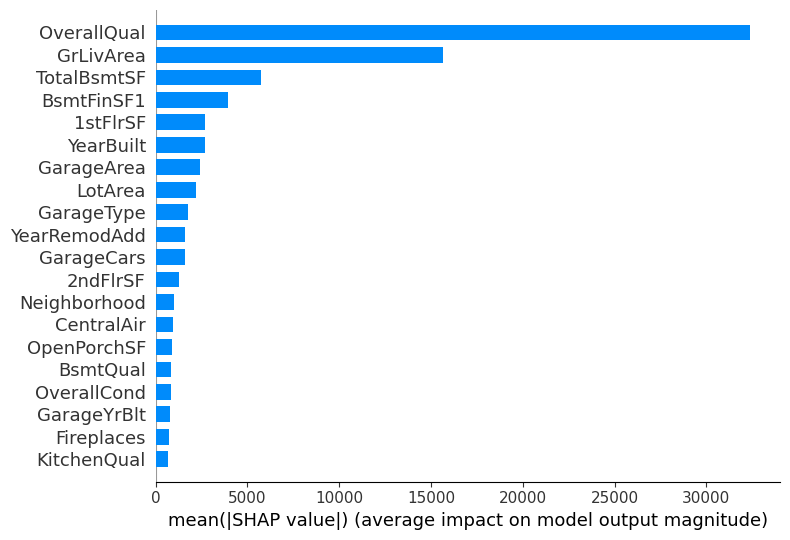

In [22]:
#shap feature importance
shap.summary_plot(shap_values, x_copy_train, plot_type="bar", plot_size=0.2)

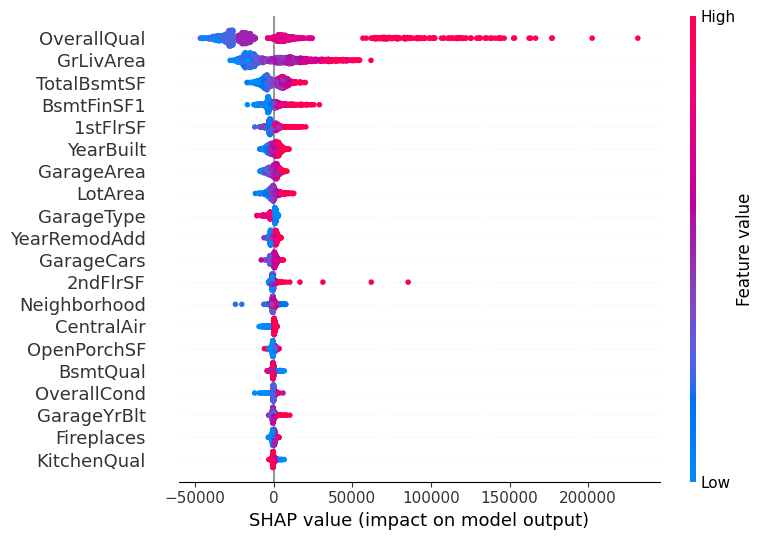

In [23]:
#summary plot
shap.summary_plot(shap_values, x_copy_train, plot_size=0.2)

### **RF Feature Importance**

In [24]:
#scores
importance = rf_regressor.feature_importances_
importance = pd.Series(importance, name="Importance Scores", index=x_copy_train.columns)
importance = importance.sort_values(ascending=False)
importance = importance.iloc[:20]

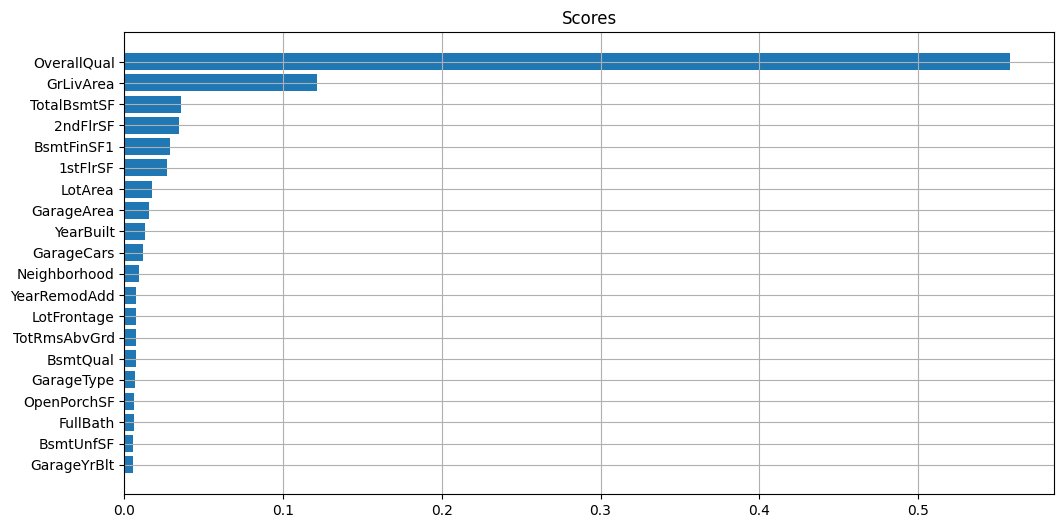

In [26]:
#plot dos 20 mais importantes
importance = importance.sort_values(ascending=True)
plt.figure(dpi=100, figsize=(12, 6))
width = np.arange(len(importance))
ticks = list(importance.index)
plt.barh(width, importance)
plt.yticks(width, ticks)
plt.title("Scores")
plt.grid()

In [27]:
#valores selecionados
numeric_selected = ["GrLivArea","TotalBsmtSF", "2ndFlrSF", "1stFlrSF", "BsmtFinSF1", "LotArea", "TotRmsAbvGrd", "YearBuilt", "GarageArea", "YearRemodAdd"]
ordinal_selected = ["OverallQual","GarageCars"]
nominal_selected = ["Neighborhood","GarageType"]

## **Análise de Outliers**

In [29]:
#aplicando z-score para apenas jogar os dados para a mesma escala e plotar BoxCox das numéricas
std_scaler = StandardScaler()
numeric_scaled = std_scaler.fit_transform(dados_treino_copy[numeric_selected])
numeric_scaled = pd.DataFrame(numeric_scaled, columns = numeric_selected)

<AxesSubplot: >

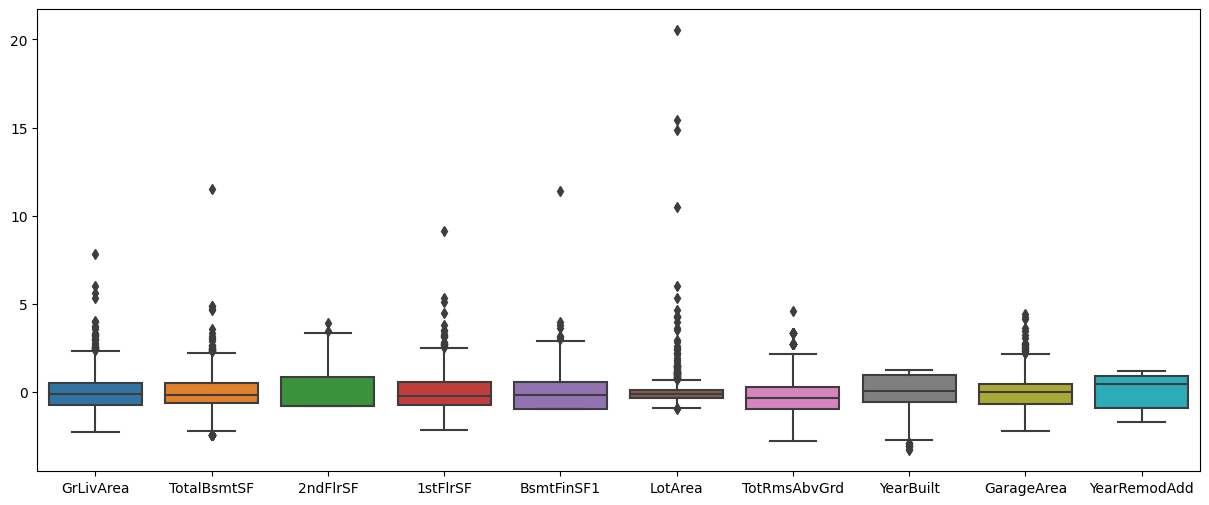

In [30]:
#plotando o BoxCox das variáveis
plt.figure(dpi=100, figsize=(15, 6))
sns.boxplot(data = numeric_scaled,orient="v")

In [31]:
#percentual de outliers por coluna
for col in  numeric_selected:
    q1 = dados_treino_copy[col].quantile(0.25)
    q3 = dados_treino_copy[col].quantile(0.75)
    iqr = q3 - q1
    qtd = sum(((dados_treino_copy[col] > (q3+1.5*iqr)) | (dados_treino_copy[col] < (q1-1.5*iqr))))
    perc = round((qtd/dados_treino_copy.shape[0])*100,2)
    print(f"Percentual de outliers para {col}: {perc}%")

Percentual de outliers para GrLivArea: 2.12%
Percentual de outliers para TotalBsmtSF: 4.18%
Percentual de outliers para 2ndFlrSF: 0.14%
Percentual de outliers para 1stFlrSF: 1.37%
Percentual de outliers para BsmtFinSF1: 0.48%
Percentual de outliers para LotArea: 4.73%
Percentual de outliers para TotRmsAbvGrd: 2.05%
Percentual de outliers para YearBuilt: 0.48%
Percentual de outliers para GarageArea: 1.44%
Percentual de outliers para YearRemodAdd: 0.0%


In [35]:
#criando um dicionário com os valores limites para substituir os outliers
outlier_limits = {}
for col in  numeric_selected:
    q1 = dados_treino_copy[col].quantile(0.25)
    q3 = dados_treino_copy[col].quantile(0.75)
    iqr = q3 - q1
    lower = (q1-1.5*iqr)
    upper = (q3+1.5*iqr)
    if lower < 0: lower = 0
    outlier_limits[col] = [lower,upper]

In [36]:
outlier_limits

{'GrLivArea': [158.625, 2747.625],
 'TotalBsmtSF': [42.0, 2052.0],
 '2ndFlrSF': [0, 1820.0],
 '1stFlrSF': [118.125, 2155.125],
 'BsmtFinSF1': [0, 1780.625],
 'LotArea': [1481.5, 17673.5],
 'TotRmsAbvGrd': [2.0, 10.0],
 'YearBuilt': [1885.0, 2069.0],
 'GarageArea': [0, 938.25],
 'YearRemodAdd': [1911.5, 2059.5]}

In [37]:
#clip nos valores para remover os outliers
#criando um novo dataframe
dados_treino_sem_outlier = dados_treino[numeric_selected+ordinal_selected+nominal_selected+["SalePrice"]].copy()
for col in  numeric_selected:
    dados_treino_sem_outlier[col] = dados_treino_sem_outlier[col].clip(outlier_limits[col][0],outlier_limits[col][1])

## **Análise de correlação**

### **Features numéricas**

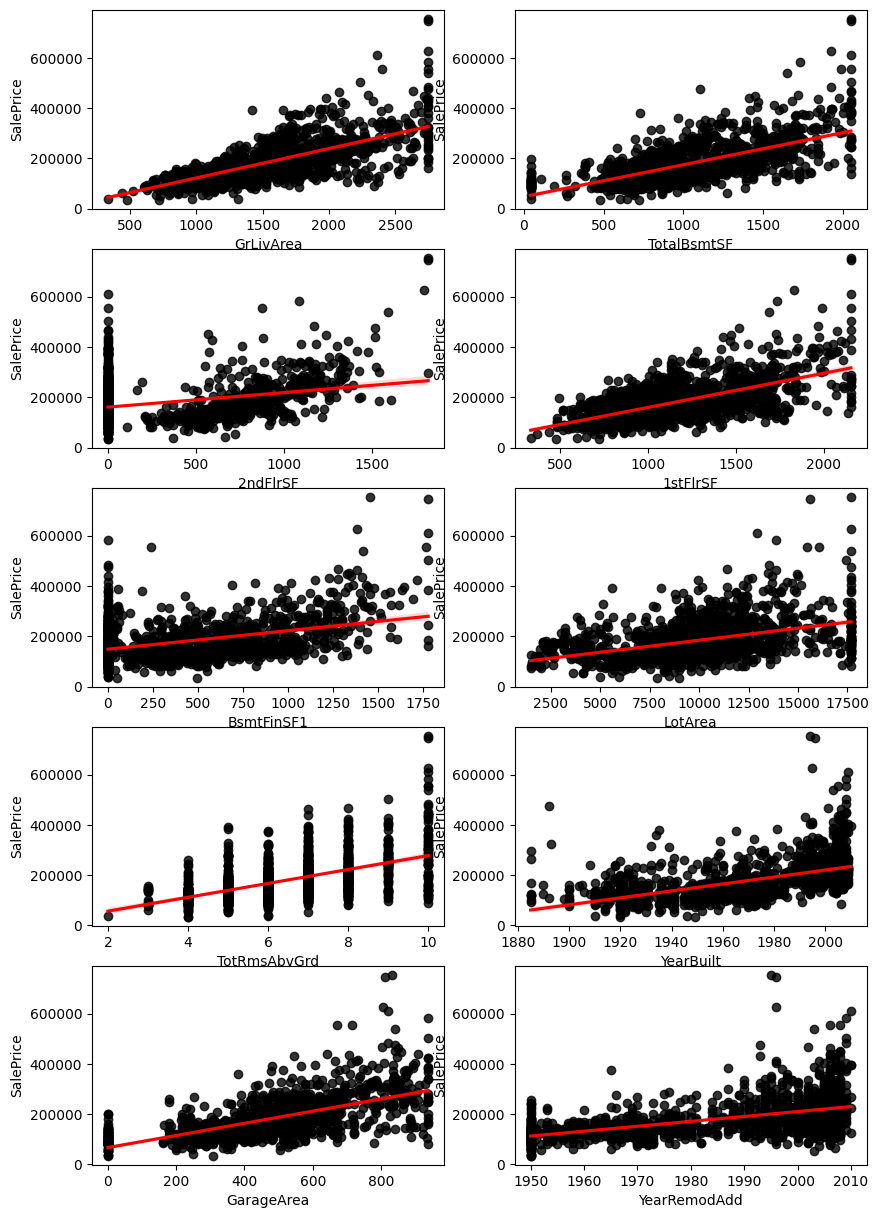

In [38]:
#Scatter plot para todas as variáveis numéricas comparando com a target
fig, axs = plt.subplots(5,2,figsize=(10,15),dpi=100)
i = 0
for line in range(5):
    for col in range(2):
        sns.regplot(x = dados_treino_sem_outlier[numeric_selected[i]], y = dados_treino_sem_outlier["SalePrice"], 
                    scatter_kws={"color": "black"}, line_kws={"color": "red"}, ax = axs[line][col])
        i += 1

<AxesSubplot: >

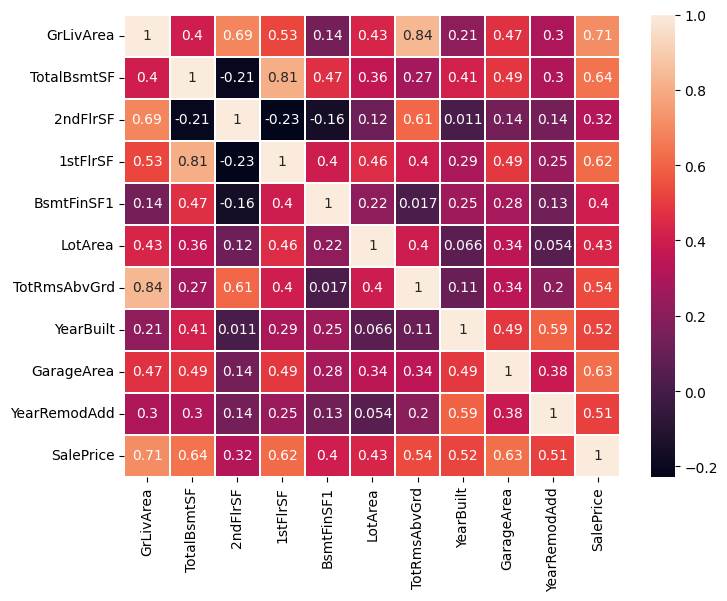

In [39]:
#matriz de correlação de Pearson
pearson_corr = dados_treino_sem_outlier[numeric_selected + ["SalePrice"]].corr()
plt.figure(figsize=(8,6))
sns.heatmap(pearson_corr, linewidths = 0.1, cbar_kws={"orientation": "vertical"}, annot=True)

<AxesSubplot: >

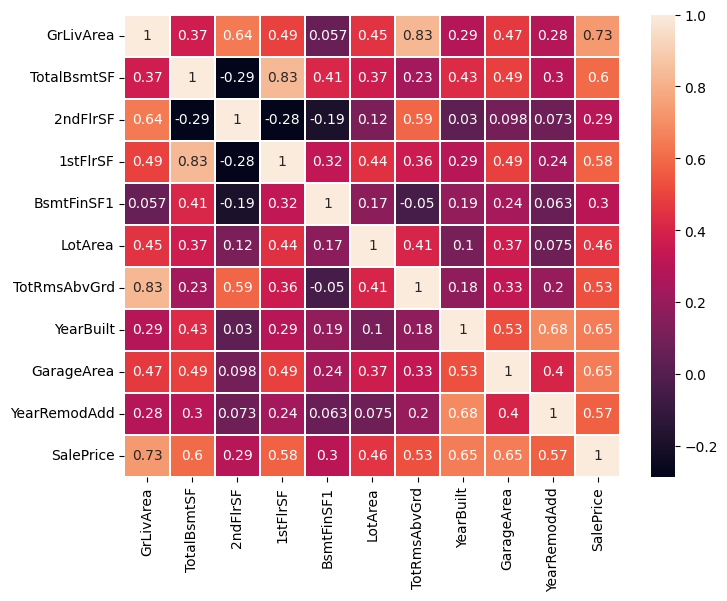

In [40]:
#matriz de correlação de Spearman
spearman_corr = dados_treino_sem_outlier[numeric_selected + ["SalePrice"]].corr(method="spearman")
plt.figure(figsize=(8,6))
sns.heatmap(spearman_corr, linewidths = 0.1, cbar_kws={"orientation": "vertical"}, annot=True)

In [41]:
#correlação de Pearson por ordem de grandeza
abs_pearson_corr = abs(pearson_corr["SalePrice"])
abs_pearson_corr.sort_values(ascending = False)

SalePrice       1.000000
GrLivArea       0.708153
TotalBsmtSF     0.636999
GarageArea      0.630138
1stFlrSF        0.620743
TotRmsAbvGrd    0.536067
YearBuilt       0.524172
YearRemodAdd    0.507101
LotArea         0.432216
BsmtFinSF1      0.400330
2ndFlrSF        0.316547
Name: SalePrice, dtype: float64

In [42]:
#correlação de Spearman por ordem de grandeza
abs_spearman_corr = abs(spearman_corr["SalePrice"])
abs_spearman_corr.sort_values(ascending = False)

SalePrice       1.000000
GrLivArea       0.731354
YearBuilt       0.652682
GarageArea      0.649438
TotalBsmtSF     0.602754
1stFlrSF        0.575419
YearRemodAdd    0.571159
TotRmsAbvGrd    0.532612
LotArea         0.456000
BsmtFinSF1      0.301882
2ndFlrSF        0.293598
Name: SalePrice, dtype: float64

### **Features ordinais**

<AxesSubplot: >

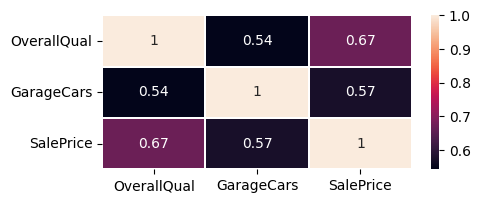

In [43]:
#matriz de correlação de Kendall
kendall_corr = dados_treino_sem_outlier[ordinal_selected + ["SalePrice"]].corr(method="kendall")
plt.figure(figsize=(5,2))
sns.heatmap(kendall_corr, linewidths = 0.1, cbar_kws={"orientation": "vertical"}, annot=True)

In [44]:
#teste Anova
ordinal_anova = SelectKBest(score_func=f_regression,k="all")
ordinal_anova.fit(dados_treino_sem_outlier[ordinal_selected],dados_treino_sem_outlier["SalePrice"])
for col, pvalue in zip(ordinal_selected,ordinal_anova.pvalues_):
        print(f"{col} p-value: {pvalue}")

OverallQual p-value: 2.185675268e-313
GarageCars p-value: 2.498644167176248e-169


### **Features nominais**

In [46]:
#aplicando OHE nas variáveis
ohe_features = pd.get_dummies(dados_treino_sem_outlier[nominal_selected])

In [47]:
#teste Anova
nominal_anova = SelectKBest(score_func=f_regression,k="all")
nominal_anova.fit(ohe_features,dados_treino_sem_outlier["SalePrice"])
nominal_anova_df = pd.DataFrame(zip(ohe_features.columns,nominal_anova.pvalues_), columns = ["Feature","Pvalue"])
nominal_anova_df[nominal_anova_df.Pvalue > 0.05] # features que devem ser removidas, já que o pvalue é maior que 0.05

,Feature,Pvalue
0,Neighborhood_Blmngtn,0.466651
1,Neighborhood_Blueste,0.439414
8,Neighborhood_Gilbert,0.169902
13,Neighborhood_NPkVill,0.147671
14,Neighborhood_NWAmes,0.369916
20,Neighborhood_SawyerW,0.578282
25,GarageType_2Types,0.359991
27,GarageType_Basment,0.261180


# **Modelagem**

A partir desse ponto, a partir das informações obtidas nas seções anteriores, serão exploradas as possibilidades de modelos de regressão para o problema.

As principais atividades que serão desenvolvidas são:

- Model Selection: escolha do melhor modelo a partir de testes
- Fine Tuning: otimização de parâmetros do modelo
- Geração do score para submeter no Kaggle
    
As três etapas podem ser repetidas diversas vezes em diversos cenários, na busca de melhorar os resultados

## **Model Selection**

### **Dataprep**

In [48]:
#features que serão utilizadas
numeric_features = ["GrLivArea","TotalBsmtSF", "1stFlrSF", "TotRmsAbvGrd", "YearBuilt", "GarageArea", "YearRemodAdd"]
ordinal_features = ["OverallQual","GarageCars"]
nominal_features = ["Neighborhood","GarageType"]

In [63]:
#criando os valores de X e Y
X_selected = dados_treino[numeric_features+ordinal_features+nominal_features].copy()
Y_selected = dados_treino["SalePrice"].copy()

In [64]:
#removendo outliers das colunas numéricas
for col in  numeric_features:
    X_selected[col] = X_selected[col].clip(outlier_limits[col][0],outlier_limits[col][1])

In [87]:
#criando o OHE para as features nominais e dropando as colunas que não devem ser consideradas
neighborhood = ['BrDale', 'BrkSide', 'ClearCr', 'CollgCr',
'Crawfor', 'Edwards', 'IDOTRR', 'MeadowV', 'Mitchel',
'NAmes', 'NoRidge', 'NridgHt', 'OldTown',
'SWISU', 'Sawyer', 'Somerst', 'StoneBr', 'Timber',
'Veenker']
garage_type = ['Attchd', 'BuiltIn', 'CarPort', 'Detchd','NA']
nominal_transformer = OneHotEncoder(categories=[neighborhood,garage_type], handle_unknown="ignore",sparse=False)

In [134]:
#criando o transformer de pré-processamento
numeric_transformer = RobustScaler()
ordinal_transformer = OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=-1)
preprocessor = ColumnTransformer(transformers=[
    ("num", numeric_transformer , numeric_features),
    ("ord", ordinal_transformer , ordinal_features),
    ("nom", nominal_transformer , nominal_features)
    ])

### **Regressão Linear**

In [135]:
%%time
reg_lin = LinearRegression()
reg_lin_pipeline = Pipeline(steps=[("preprocessor",preprocessor),("model",reg_lin)])
reg_lin_scores = cross_val_score(reg_lin_pipeline, X_selected, Y_selected,cv=5,scoring='neg_root_mean_squared_error')
print(abs(reg_lin_scores))
print(f'RMSE médio: {round(abs(reg_lin_scores.mean()))}')
print(f'Desvio padrão: {round(abs(reg_lin_scores.std()))}')

[29724.42335561 33550.9220733  38650.8095429  30524.03203611
 40108.91820871]
RMSE médio: 34512
Desvio padrão: 4200
CPU times: total: 438 ms
Wall time: 245 ms


### **SVM**

In [136]:
%%time
svr = LinearSVR()
svr_pipeline = Pipeline(steps=[("preprocessor",preprocessor),("model",svr)])
svr_scores = cross_val_score(svr_pipeline, X_selected, Y_selected,cv=5,scoring='neg_root_mean_squared_error', error_score="raise")
print(abs(svr_scores))
print(f'RMSE médio: {round(abs(svr_scores.mean()))}')
print(f'Desvio padrão: {round(abs(svr_scores.std()))}')

[160348.34726846 174170.67875784 168531.74297848 151758.45659493
 164114.03521175]
RMSE médio: 163785
Desvio padrão: 7576
CPU times: total: 406 ms
Wall time: 225 ms


### **RandomForest**

In [137]:
%%time
rf = RandomForestRegressor(random_state=0)
rf_pipeline = Pipeline(steps=[("preprocessor",preprocessor),("model",rf)])
rf_scores = cross_val_score(rf_pipeline, X_selected, Y_selected,cv=5,scoring='neg_root_mean_squared_error')
print(abs(rf_scores))
print(f'RMSE médio: {round(abs(rf_scores.mean()))}')
print(f'Desvio padrão: {round(abs(rf_scores.std()))}')

[29045.54554843 32071.49840913 31150.89823122 25451.78035054
 34039.77243614]
RMSE médio: 30352
Desvio padrão: 2930
CPU times: total: 10.9 s
Wall time: 11.1 s


### **AdaBoost**

In [138]:
%%time
ada = AdaBoostRegressor(random_state=0)
ada_pipeline = Pipeline(steps=[("preprocessor",preprocessor),("model",ada)])
ada_scores = cross_val_score(ada_pipeline, X_selected, Y_selected,cv=5,scoring='neg_root_mean_squared_error')
print(abs(ada_scores))
print(f'RMSE médio: {round(abs(ada_scores.mean()))}')
print(f'Desvio padrão: {round(abs(ada_scores.std()))}')

[33077.79896584 38817.25392878 37290.65489305 31972.12549402
 36585.9682148 ]
RMSE médio: 35549
Desvio padrão: 2596
CPU times: total: 1.72 s
Wall time: 1.75 s


### **XGBoost**

In [139]:
%%time
xgb = XGBRegressor(random_state=0)
xgb_pipeline = Pipeline(steps=[("preprocessor",preprocessor),("model",xgb)])
xgb_scores = cross_val_score(xgb_pipeline, X_selected, Y_selected,cv=5,scoring='neg_root_mean_squared_error')
print(abs(xgb_scores))
print(f'RMSE médio: {round(abs(xgb_scores.mean()))}')
print(f'Desvio padrão: {round(abs(xgb_scores.std()))}')

[27816.23396894 38850.78749546 32367.85854792 23876.14590008
 29450.45185596]
RMSE médio: 30472
Desvio padrão: 5008
CPU times: total: 6.86 s
Wall time: 1.97 s


## **Fine Tuning**

Para o Fine Tuning, os modelos considerados são aqueles com melhor desempenho na etapa anterior: Random Forest e XGBoost

### **Randomized Search**

In [143]:
%%time
#preparando para o modelo de RF
rf_rs = RandomForestRegressor(random_state=0)
rf_rs_pipeline = Pipeline(steps=[("preprocessor",preprocessor),("model",rf_rs)])
rf_random_grid = {
    'model__bootstrap': [True, False],
    'model__max_depth': [5, 10, 20, 30, None],
    'model__max_features': ['log2', 'sqrt', 1.0],
    'model__min_samples_leaf': [1, 2, 4],
    'model__min_samples_split': [2, 5, 10],
    'model__n_estimators': [100, 200, 500, 1000, 1500, 2000]
}
rf_random_search = RandomizedSearchCV(rf_rs_pipeline, rf_random_grid, n_iter=100, cv=5, scoring='neg_root_mean_squared_error', random_state=0)
rf_random_search.fit(X_selected, Y_selected)

CPU times: total: 37min 12s
Wall time: 42min 9s


RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(transformers=[('num',
                                                                               RobustScaler(),
                                                                               ['GrLivArea',
                                                                                'TotalBsmtSF',
                                                                                '1stFlrSF',
                                                                                'TotRmsAbvGrd',
                                                                                'YearBuilt',
                                                                                'GarageArea',
                                                                                'YearRemodAdd']),
                                                                              ('ord',
                                                                               OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                                              unknown_value=-1),
                                                                               ['OverallQual',
                                                                                'GarageCars']),
                                                                              ('nom',
                                                                               OneHotEncoder(categorie...
                                              RandomForestRegressor(random_state=0))]),
                   n_iter=100,
                   param_distributions={'model__bootstrap': [True, False],
                                        'model__max_depth': [5, 10, 20, 30,
                                                             None],
                                        'model__max_features': ['log2', 'sqrt',
                                                                1.0],
                                        'model__min_samples_leaf': [1, 2, 4],
                                        'model__min_samples_split': [2, 5, 10],
                                        'model__n_estimators': [100, 200, 500,
                                                                1000, 1500,
                                                                2000]},
                   random_state=0, scoring='neg_root_mean_squared_error')

In [144]:
#melhores parâmetros e performance do melhor estimator
print(rf_random_search.best_params_)
print(rf_random_search.best_score_)

{'model__n_estimators': 1000, 'model__min_samples_split': 2, 'model__min_samples_leaf': 1, 'model__max_features': 'log2', 'model__max_depth': 30, 'model__bootstrap': False}
-28605.10118492455


In [145]:
%%time
#preparando para o modelo de XGBoost
xgb_rs = XGBRegressor(random_state=0)
xgb_rs_pipeline = Pipeline(steps=[("preprocessor",preprocessor),("model",xgb_rs)])
xgb_random_grid = {
    'model__n_estimators': [100, 200, 500, 1000, 1500, 2000],
    'model__max_depth': [5, 10, 20, 30, None],
    'model__learning_rate': [0.05, 0.1, 0.2, None],
    'model__min_child_weight': [1, 10, 50, 100, None]
}
xgb_random_search = RandomizedSearchCV(xgb_rs_pipeline, xgb_random_grid, n_iter=100, cv=5, scoring='neg_root_mean_squared_error', random_state=0)
xgb_random_search.fit(X_selected, Y_selected)

CPU times: total: 1h 6min 44s
Wall time: 23min


RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(transformers=[('num',
                                                                               RobustScaler(),
                                                                               ['GrLivArea',
                                                                                'TotalBsmtSF',
                                                                                '1stFlrSF',
                                                                                'TotRmsAbvGrd',
                                                                                'YearBuilt',
                                                                                'GarageArea',
                                                                                'YearRemodAdd']),
                                                                              ('ord',
                                                                               OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                                              unknown_value=-1),
                                                                               ['OverallQual',
                                                                                'GarageCars']),
                                                                              ('nom',
                                                                               OneHotEncoder(categorie...
                                                           n_estimators=100,
                                                           n_jobs=None,
                                                           num_parallel_tree=None,
                                                           predictor=None,
                                                           random_state=0, ...))]),
                   n_iter=100,
                   param_distributions={'model__learning_rate': [0.05, 0.1, 0.2,
                                                                 None],
                                        'model__max_depth': [5, 10, 20, 30,
                                                             None],
                                        'model__min_child_weight': [1, 10, 50,
                                                                    100, None],
                                        'model__n_estimators': [100, 200, 500,
                                                                1000, 1500,
                                                                2000]},
                   random_state=0, scoring='neg_root_mean_squared_error')

In [146]:
#melhores parâmetros e performance do melhor estimator
print(xgb_random_search.best_params_)
print(xgb_random_search.best_score_)

{'model__n_estimators': 500, 'model__min_child_weight': 10, 'model__max_depth': 5, 'model__learning_rate': 0.05}
-29739.07018404134


### **Grid Search**

In [148]:
%%time
#preparando para o modelo de RF
rf_gs = RandomForestRegressor(random_state=0)
rf_gs_pipeline = Pipeline(steps=[("preprocessor",preprocessor),("model",rf_gs)])
rf_grid_grid = {
    'model__bootstrap': [True, False],
    'model__max_depth': [28,30,32],
    'model__max_features': ['log2', 'sqrt'],
    'model__min_samples_leaf': [1,2,3,5],
    'model__min_samples_split': [2,3,4,5],
    'model__n_estimators': [900, 1000, 1100]
}
rf_grid_search = GridSearchCV(rf_gs_pipeline, rf_grid_grid, cv=5, scoring='neg_root_mean_squared_error')
rf_grid_search.fit(X_selected, Y_selected)

CPU times: total: 1h 52min 41s
Wall time: 1h 53min 14s


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         RobustScaler(),
                                                                         ['GrLivArea',
                                                                          'TotalBsmtSF',
                                                                          '1stFlrSF',
                                                                          'TotRmsAbvGrd',
                                                                          'YearBuilt',
                                                                          'GarageArea',
                                                                          'YearRemodAdd']),
                                                                        ('ord',
                                                                         OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                                        unknown_value=-1),
                                                                         ['OverallQual',
                                                                          'GarageCars']),
                                                                        ('nom',
                                                                         OneHotEncoder(categories=[['B...
                                                                                       sparse=False),
                                                                         ['Neighborhood',
                                                                          'GarageType'])])),
                                       ('model',
                                        RandomForestRegressor(random_state=0))]),
             param_grid={'model__bootstrap': [True, False],
                         'model__max_depth': [28, 30, 32],
                         'model__max_features': ['log2', 'sqrt'],
                         'model__min_samples_leaf': [1, 2, 3, 5],
                         'model__min_samples_split': [2, 3, 4, 5],
                         'model__n_estimators': [900, 1000, 1100]},
             scoring='neg_root_mean_squared_error')

In [149]:
#melhores parâmetros e performance do melhor estimator
print(rf_grid_search.best_params_)
print(rf_grid_search.best_score_)

{'model__bootstrap': False, 'model__max_depth': 32, 'model__max_features': 'log2', 'model__min_samples_leaf': 1, 'model__min_samples_split': 2, 'model__n_estimators': 900}
-28590.579576939326


In [150]:
%%time
#preparando para o modelo de XGBoost
xgb_gs = XGBRegressor(random_state=0)
xgb_gs_pipeline = Pipeline(steps=[("preprocessor",preprocessor),("model",xgb_gs)])
xgb_grid_grid = {
    'model__n_estimators': [400, 500, 600],
    'model__max_depth': [4,5,6],
    'model__learning_rate': [0.05, 0.1],
    'model__min_child_weight': [5, 10, 15]
}
xgb_grid_search = GridSearchCV(xgb_gs_pipeline, xgb_grid_grid, cv=5, scoring='neg_root_mean_squared_error')
xgb_grid_search.fit(X_selected, Y_selected)

CPU times: total: 11min 36s
Wall time: 2min 55s


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         RobustScaler(),
                                                                         ['GrLivArea',
                                                                          'TotalBsmtSF',
                                                                          '1stFlrSF',
                                                                          'TotRmsAbvGrd',
                                                                          'YearBuilt',
                                                                          'GarageArea',
                                                                          'YearRemodAdd']),
                                                                        ('ord',
                                                                         OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                                        unknown_value=-1),
                                                                         ['OverallQual',
                                                                          'GarageCars']),
                                                                        ('nom',
                                                                         OneHotEncoder(categories=[['B...
                                                     max_leaves=None,
                                                     min_child_weight=None,
                                                     missing=nan,
                                                     monotone_constraints=None,
                                                     n_estimators=100,
                                                     n_jobs=None,
                                                     num_parallel_tree=None,
                                                     predictor=None,
                                                     random_state=0, ...))]),
             param_grid={'model__learning_rate': [0.05, 0.1],
                         'model__max_depth': [4, 5, 6],
                         'model__min_child_weight': [5, 10, 15],
                         'model__n_estimators': [400, 500, 600]},
             scoring='neg_root_mean_squared_error')

In [151]:
#melhores parâmetros e performance do melhor estimator
print(xgb_grid_search.best_params_)
print(xgb_grid_search.best_score_)

{'model__learning_rate': 0.1, 'model__max_depth': 4, 'model__min_child_weight': 5, 'model__n_estimators': 400}
-28951.35141685609


In [155]:
#salvando o melhor modelo de RF
rf_pipeline_v1 = rf_grid_search.best_estimator_
pickle.dump(rf_pipeline_v1, open("Modelos/rf_pipeline_v1.pkl", 'wb'))

In [156]:
#salvando o melhor modelo de XGBoost
xgb_pipeline_v1 = xgb_grid_search.best_estimator_
pickle.dump(xgb_pipeline_v1, open("Modelos/xgb_pipeline_v1.pkl", 'wb'))

## **Escoragens**

In [158]:
#carregando o conjunto de dados de teste
dados_test = pd.read_csv('Dados/test.csv', index_col = 'Id')
dados_test.sample(5)

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
Id,,,,,,,,,,,,,,,,,,,,,
2777,70,RM,58.0,6451,Pave,Grvl,Reg,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,5,2006,WD,Normal
2351,20,FV,84.0,10440,Pave,NaN,Reg,Lvl,AllPub,Corner,...,0,0,NaN,NaN,NaN,0,5,2007,New,Partial
1625,20,RL,74.0,13008,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,10,2009,WD,Normal
1781,20,RL,60.0,9600,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,0,NaN,GdWo,NaN,0,8,2009,WD,Normal
1580,60,RL,NaN,9337,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,4,2010,WD,Normal


In [168]:
dados_test.shape

(1459, 79)

In [163]:
#preenchendo os valores "falsos nulos", assim como feito no conjunto de treino
cols_to_fill = ["Alley","FireplaceQu","PoolQC","Fence","MiscFeature","BsmtQual", "BsmtCond", "BsmtFinType1", "BsmtFinType2",
                "BsmtExposure","GarageType","GarageFinish", "GarageQual", "GarageCond"]
dados_test[cols_to_fill] = dados_test[cols_to_fill].fillna("NA")
dados_test[cols_to_fill].sample(5)
dados_test.MasVnrArea = dados_test.MasVnrArea.fillna(0)
dados_test.MasVnrType = dados_test.MasVnrType.fillna("None")
dados_test.Electrical = dados_test.Electrical.fillna(dados_test.Electrical.mode()[0])
dados_test.LotFrontage = dados_test.LotFrontage.fillna(float(int(dados_test.LotFrontage.mean())))
dados_test.GarageYrBlt = dados_test.GarageYrBlt.fillna(float(int(dados_test.GarageYrBlt.median())))
dados_test.fillna(0,inplace=True)

In [164]:
dados_test.isnull().sum()[dados_test.isnull().sum() > 0]

Series([], dtype: int64)

### **Versão 1**

In [165]:
X_test_v1 = dados_test[numeric_features+ordinal_features+nominal_features].copy()

In [166]:
#removendo outliers das colunas numéricas
for col in  numeric_features:
    X_test_v1[col] = X_test_v1[col].clip(outlier_limits[col][0],outlier_limits[col][1])

In [169]:
X_test_v1.sample(5)

,GrLivArea,TotalBsmtSF,1stFlrSF,TotRmsAbvGrd,YearBuilt,GarageArea,YearRemodAdd,OverallQual,GarageCars,Neighborhood,GarageType
Id,,,,,,,,,,,
2118,1342.0,739.0,874.0,7,1939,240.0,1950,6,1.0,BrkSide,Detchd
2542,1536.0,768.0,768.0,6,2005,400.0,2005,5,2.0,CollgCr,Attchd
2362,2503.0,1223.0,1271.0,7,1990,564.0,1990,7,2.0,Veenker,Attchd
2840,1425.0,1425.0,1425.0,5,1998,591.0,1998,7,2.0,CollgCr,Attchd
1580,1692.0,878.0,892.0,8,1997,513.0,1998,7,2.0,CollgCr,Attchd


In [172]:
#gerando a escoragem com RF
rf_previsoes_v1 = pd.DataFrame(rf_pipeline_v1.predict(X_test_v1), columns=['SalePrice'])
rf_previsoes_v1.index = X_test_v1.index
rf_previsoes_v1.to_csv('Escoragens/rf_previsoes_v1.csv')

In [173]:
#gerando a escoragem com XGBoost
xgb_previsoes_v1 = pd.DataFrame(xgb_pipeline_v1.predict(X_test_v1), columns=['SalePrice'])
xgb_previsoes_v1.index = X_test_v1.index
xgb_previsoes_v1.to_csv('Escoragens/xgb_previsoes_v1.csv')